# Alresford, network analysis

***first added 28 September 2020***

## Imports

In [1]:
import geopandas
import networkx as nx
import osmnx as ox
import contextily as ctx
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

ox.config(use_cache=True,
          log_console=True,
         )

## Get the street network and calculate centrality values

- Geocode Alresford to its boundary buffered by 100m
- Get its street network
- Use OSMnx to calculate extended network statistics inluding
    - betweenness centrality
    - closeness centrality
    - degree centrality
- Write them into the data for each node

In [2]:
# Geocode Alresford to its boundary and buffer by 100m
study_boundary = ox.geocode_to_gdf('New Alresford, Hampshire', buffer_dist=100)

# Get the driveable street network
G = ox.graph_from_polygon(study_boundary['geometry'].values[0],
                          network_type='drive')

# Calculate extended stats including centralities
ext_stats = ox.extended_stats(G, bc=True, cc=True)

# Add the centrality values into the node data attributes
nx.set_node_attributes(G, ext_stats['betweenness_centrality'], name='bc')
nx.set_node_attributes(G, ext_stats['closeness_centrality'], name='cc')
nx.set_node_attributes(G, ext_stats['degree_centrality'], name='dc')

## Convert the graph nodes to a geodataframe and reproject
- Extract the nodes from the graph to a geodataframe
- Reproject to Web Mercator, compatible with contextily

In [3]:
GDF_nodes_prj = ox.graph_to_gdfs(G, edges=False)

# reproject to a CRS suitable for web tiles
study_boundary_prj = study_boundary.to_crs(epsg=3857)
GDF_nodes_prj.to_crs(epsg=3857, inplace=True)

print(GDF_nodes_prj.crs)
GDF_nodes_prj.head(2)

epsg:3857


,y,x,osmid,bc,cc,dc,highway,geometry
251818,51.089889,-1.164434,251818,0.238551,0.000986,0.028986,NaN,POINT (-129624.211 6637209.493)
271155,51.090592,-1.161341,271155,0.048011,0.000854,0.021739,NaN,POINT (-129279.911 6637334.106)


## Plot street junctions coloured by betweenness centrality

- plot boundary of initial query
- divide the axis for better handling of the color bar
- color nodes by their betweenness centrality
- use contextily to add a base map

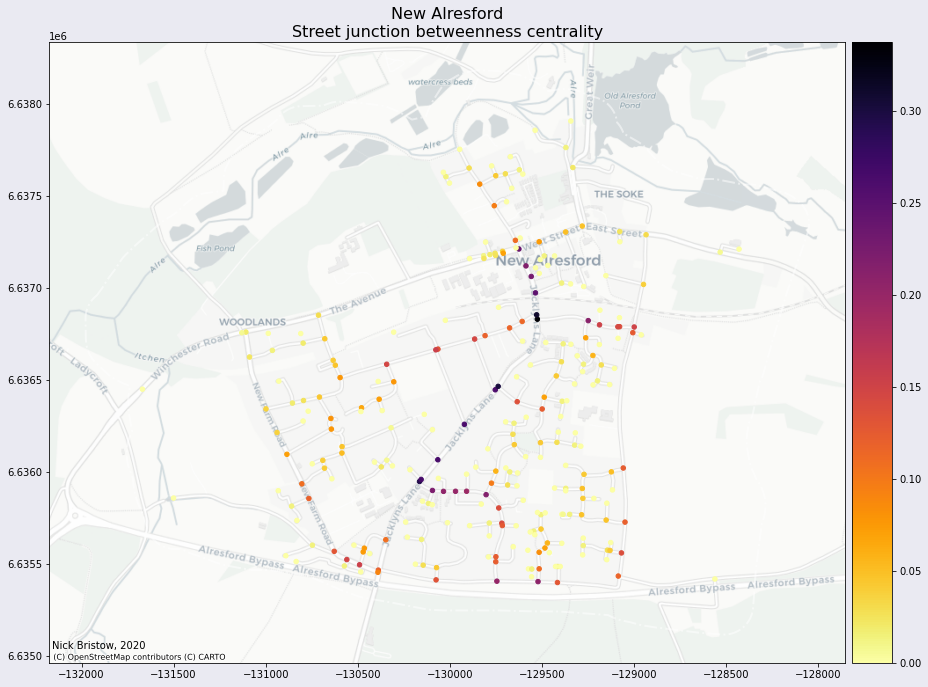

In [4]:
fig, ax = plt.subplots(figsize=(13,13))
fig.set_facecolor('#EAEAF2')

# Plot titles
ax.set_title(label='New Alresford\nStreet junction betweenness centrality',
             fontdict={'fontsize':16,
                      })

study_boundary_prj.plot(
                 ax=ax,
                 alpha=0.5,
                 facecolor='none',
                 edgecolor='w',
                 linewidth=2,
                 linestyle='-.')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

GDF_nodes_prj.plot(ax=ax,
                   column='bc',
                   cmap='inferno_r',
                   markersize=20,
                   legend=True,
                   cax=cax,
                   )

ctx.add_basemap(ax, zoom=15, source=ctx.providers.CartoDB.Positron)

ax.text(-132160,6635040,"Nick Bristow, 2020")
# Save the file
fig.tight_layout()
fig.savefig('New_Alresford_betweenness_centrality', facecolor='#EAEAF2')

## Plot street junctions coloured by closeness centrality

- plot boundary of initial query
- divide the axis for better handling of the color bar
- color nodes by their closeness centrality
- use contextily to add a base map

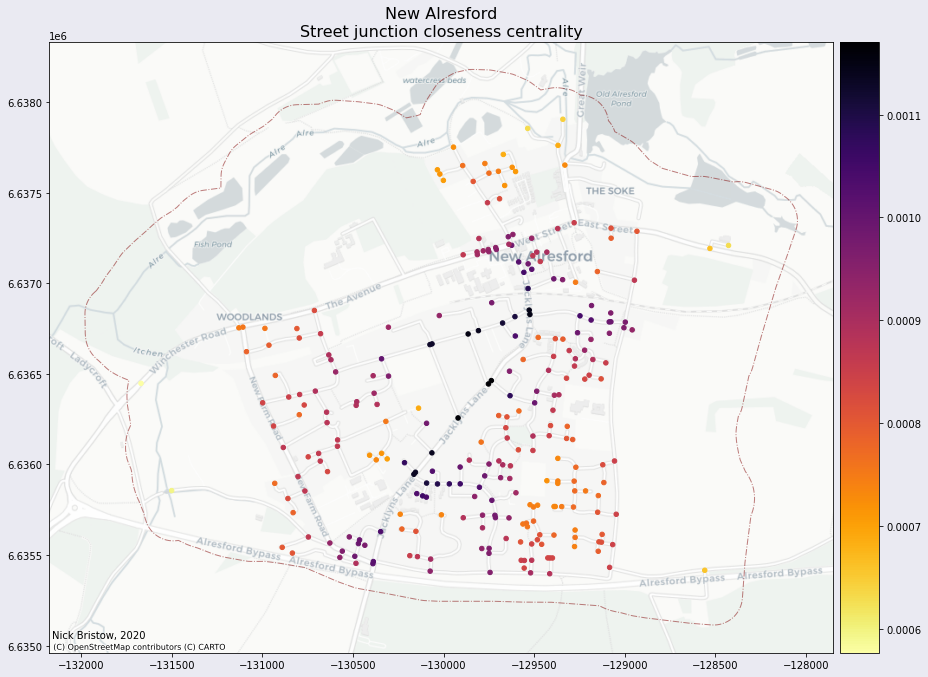

In [5]:
fig, ax = plt.subplots(figsize=(13,13))
fig.set_facecolor('#EAEAF2')

# Plot titles
ax.set_title(label='New Alresford\nStreet junction closeness centrality',
             fontdict={'fontsize':16,
                      })

study_boundary_prj.plot(
                 ax=ax,
                 alpha=0.5,
                 facecolor='none',
                 edgecolor='maroon',
                 linewidth=1,
                 linestyle='-.')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

GDF_nodes_prj.plot(ax=ax,
                   column='cc',
                   cmap='inferno_r',
                   markersize=20,
                   legend=True,
                   cax=cax,
                   )
ctx.add_basemap(ax, zoom=15, source=ctx.providers.CartoDB.Positron)

ax.text(-132160,6635040,"Nick Bristow, 2020")
# Save the file
fig.tight_layout()
fig.savefig('New_Alresford_closeness_centrality', facecolor='#EAEAF2')

## What is this really showing us?

- Extract two overlapping graphs from Buenos Aires' street network
- Measure centrality metrics for both
- Convert to a GeoDataFrame
- Create two axes showing that the measured closeness centrality of nodes in the overlapping area depends on their position relative to the rest of the nodes that are being analysed.

In [12]:
BA_G_0 = ox.graph_from_point((-34.5044,-58.5030), dist=800, network_type='drive')
BA_G_1 = ox.graph_from_point((-34.5044,-58.4916), dist=800, network_type='drive')

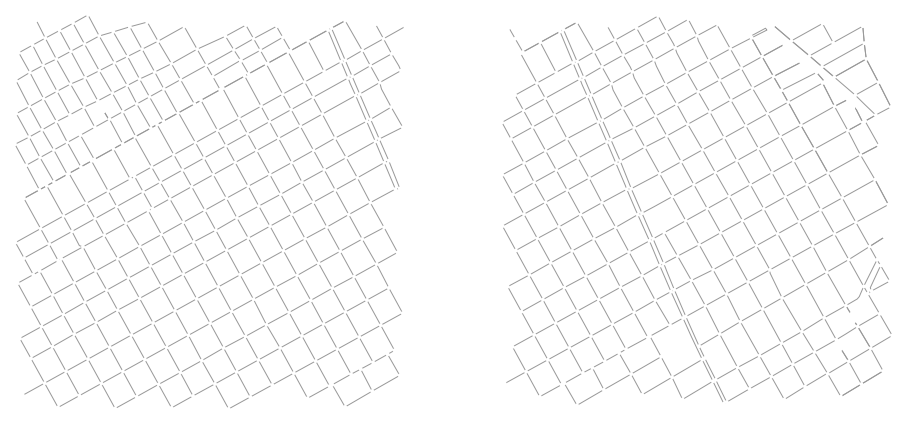

(<Figure size 1152x1152 with 2 Axes>, <AxesSubplot:>)

In [13]:
fig, axs = plt.subplots(1,2, figsize=(16,16), sharey=True)
ox.plot_graph(BA_G_0, ax=axs[0],show=False,close=False)
ox.plot_graph(BA_G_1, ax=axs[1],show=True,close=True)

In [14]:
%%time
def add_centrality_values(G):
    ext_stats = ox.extended_stats(G, bc=True, cc=True)

    nx.set_node_attributes(G, ext_stats['betweenness_centrality'], name='bc')
    nx.set_node_attributes(G, ext_stats['closeness_centrality'], name='cc')
    nx.set_node_attributes(G, ext_stats['degree_centrality'], name='dc')
    
    return G

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [15]:
BA_G_0 = add_centrality_values(BA_G_0)
BA_G_1 = add_centrality_values(BA_G_1)

In [16]:
BA_GDF_0_nodes = ox.graph_to_gdfs(BA_G_0, edges=False)
BA_GDF_1_nodes = ox.graph_to_gdfs(BA_G_1, edges=False)

BA_GDF_0_nodes_prj = BA_GDF_0_nodes.to_crs(epsg=3857)
BA_GDF_1_nodes_prj = BA_GDF_1_nodes.to_crs(epsg=3857)

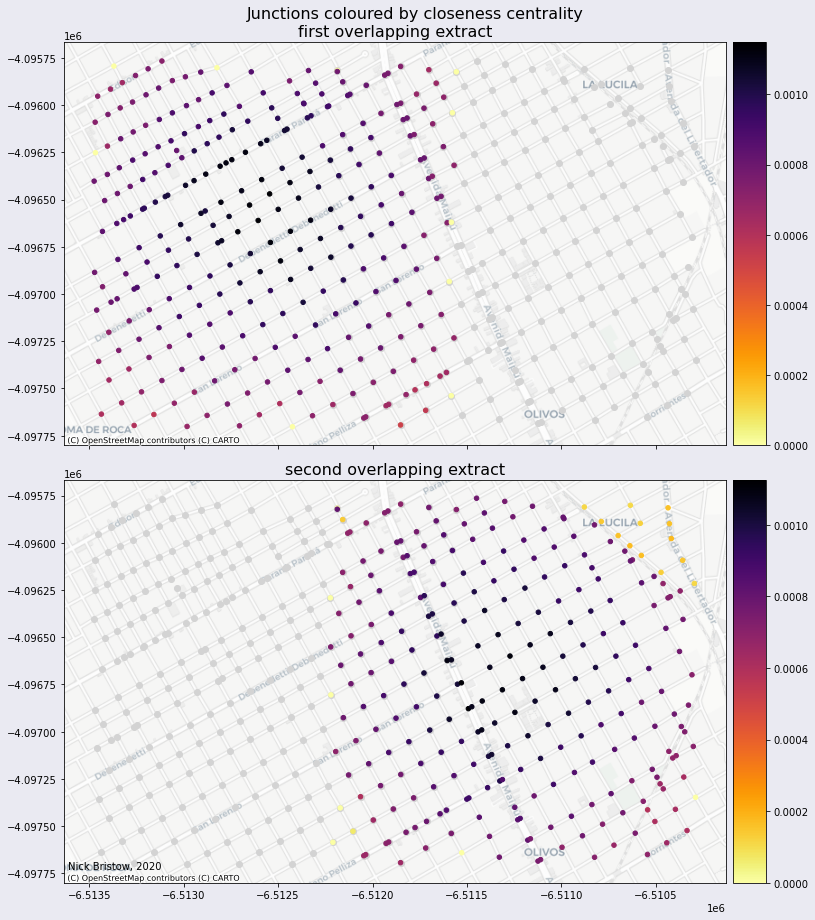

In [17]:
fig, axs = plt.subplots(2,1, figsize=(13,13), sharex=True)
fig.suptitle('Junctions coloured by closeness centrality', fontsize=16)
fig.set_facecolor('#EAEAF2')

# Plot titles
axs[0].set_title(label='first overlapping extract',
             fontdict={'fontsize':16,
                      })
axs[1].set_title(label='second overlapping extract',
             fontdict={'fontsize':16,
                      })

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.1)

BA_GDF_0_nodes_prj.plot(ax=axs[0],
                        column='cc',
                        cmap='inferno_r',
                        markersize=20,
                        legend=True,
                        zorder=2,
                        cax=cax)

BA_GDF_1_nodes_prj.plot(ax=axs[0],
                        color='lightgrey',
                        zorder=1)

ctx.add_basemap(axs[0],
                zoom=15,
                source=ctx.providers.CartoDB.Positron)

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.1)

BA_GDF_0_nodes_prj.plot(ax=axs[1],
                        color='lightgrey',
                        zorder=1)

BA_GDF_1_nodes_prj.plot(ax=axs[1],
                        column='cc',
                        cmap='inferno_r',
                        markersize=20,
                        legend=True,
                        zorder=2,
                        cax=cax)

ctx.add_basemap(axs[1],
                zoom=15,
                source=ctx.providers.CartoDB.Positron)

axs[1].text(-6513610,-4097730,"Nick Bristow, 2020")
# Save the file
fig.tight_layout()
fig.savefig('BA_closeness_centrality.png', facecolor='#EAEAF2')